# Hourly traffic volume prediction on Interstate 94

### Multivariate time series prediction with getML

In this tutorial, we demonstrate a time series application of getML. We predict the hourly traffic volume on I-94 westbound from Minneapolis-St Paul.
We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). getML's relational learning algorithms outperform Prophet's classical time series approach by ~15%.

Summary:

- Prediction type: __Regression model__
- Domain: __Transportation__
- Prediction target: __Hourly traffic volume__
- Source data: __Multivariate time series, 5 components__
- Population size: __24096__

_Author: Sören Nikolaus_

# Background

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to deal with appropriately. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


The analysis is built on top of a dataset provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

plt.style.use("seaborn")
%matplotlib inline

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.launch()
getml.engine.set_project("interstate94")

getML API version: 1.3.1

getML engine is already running.
Loading pipelines... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

Connected to project 'interstate94'
localhost:1709/#/listprojects/interstate94/


## 1. Loading data

### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made available in the example notebook featuring the full analysis. We only include data after 2016 and introduced a fixed train/test split at 80% of the available data.

In [2]:
traffic = getml.datasets.load_interstate94()


Loading traffic...
 100% |██████████| [elapsed: 00:02, remaining: 00:00]          


In [3]:
traffic

name,ds,traffic_volume,holiday,day,month,weekday,hour,year
role,time_stamp,target,categorical,categorical,categorical,categorical,categorical,categorical
unit,"time stamp, comparison only",,,day,month,weekday,hour,year
0,2016-01-01,1513,New Years Day,1,1,4,0,2016
1,2016-01-01 01:00:00,1550,New Years Day,1,1,4,1,2016
2,2016-01-01 02:00:00,993,New Years Day,1,1,4,2,2016
3,2016-01-01 03:00:00,719,New Years Day,1,1,4,3,2016
4,2016-01-01 04:00:00,533,New Years Day,1,1,4,4,2016
,...,...,...,...,...,...,...,...
24091,2018-09-30 19:00:00,3543,No holiday,30,9,6,19,2018
24092,2018-09-30 20:00:00,2781,No holiday,30,9,6,20,2018


### 1.2 Prepare data for getML

The `getml.datasets.load_interstate94` method took care of the entire data preparation:
* Downloads csv's from our servers into python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() & [units]() to columns inside getML DataFrames

__Data visualization__

The first week of the original traffic time series is plotted below.

In [4]:
col_data = "black"
col_getml = "darkviolet"

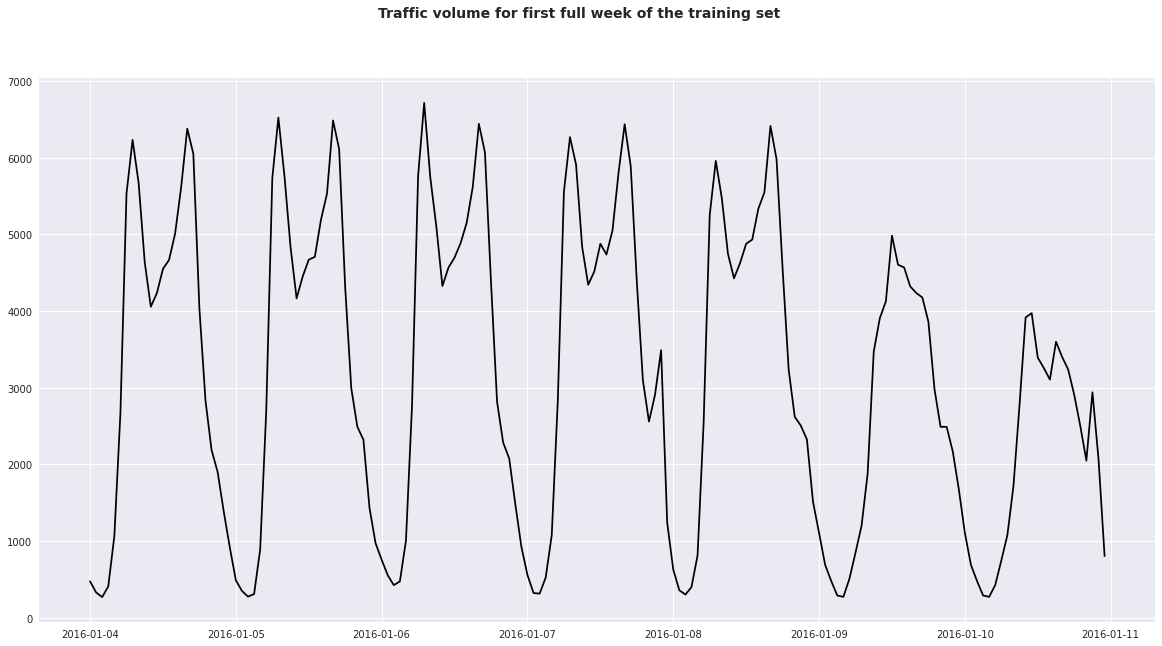

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))

# 2016/01/01 was a friday, we'd like to start the visualizations on a monday
start = 72
end = 72 + 168

fig.suptitle(
    "Traffic volume for first full week of the training set",
    fontsize=14,
    fontweight="bold",
)
ax.plot(
    traffic["ds"].to_numpy()[start:end],
    traffic["traffic_volume"].to_numpy()[start:end],
    color=col_data,
)

__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables. Note that we could have also used getML's Seasonal preprocessor (`getml.prepreprocessors.Seasonal()`), but in this case the information was already included in the dataset.

__Train/test split__

We use [getML's split functionality](https://docs.getml.com/latest/api/getml.data.split.html) to retrieve a lazily evaluated split column, that we can supply to the time series api below.

In [6]:
split = getml.data.split.time(traffic, "ds", test=getml.data.time.datetime(2018, 3, 15))

Split columns are columns of mere strings that can be used to subset the data by forming bolean conditions over them:

In [7]:
traffic[split == "test"]

name,ds,traffic_volume,holiday,day,month,weekday,hour,year
role,time_stamp,target,categorical,categorical,categorical,categorical,categorical,categorical
unit,"time stamp, comparison only",,,day,month,weekday,hour,year
0,2018-03-15,577,No holiday,15,3,3,0,2018
1,2018-03-15 01:00:00,354,No holiday,15,3,3,1,2018
2,2018-03-15 02:00:00,259,No holiday,15,3,3,2,2018
3,2018-03-15 03:00:00,360,No holiday,15,3,3,3,2018
4,2018-03-15 04:00:00,910,No holiday,15,3,3,4,2018
...,...,...,...,...,...,...,...,...


### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). We use the [high-level time series api](https://docs.getml.com/latest/api/getml.data.TimeSeries.html) for this.

Under the hood, the time series api abstracts away a self cross join of the population table (`traffic`) that allows getML's feature learning algorithms to learn patterns from past observations.

In [8]:
time_series = getml.data.TimeSeries(
    population=traffic,
    split=split,
    time_stamps="ds",
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    lagged_targets=True,
)

time_series

data model

  population:
    columns:
    - holiday: categorical
    - day: categorical
    - month: categorical
    - weekday: categorical
    - hour: categorical
    - ...

    joins:
    - right: 'traffic'
      time_stamps: (population.ds, traffic.ds)
      relationship: 'many-to-many'
      memory: 604800.0
      horizon: 3600.0
      lagged_targets: True

  traffic:
    columns:
    - holiday: categorical
    - day: categorical
    - month: categorical
    - weekday: categorical
    - hour: categorical
    - ...


container

  population
      subset   name       rows   type
  0   test     traffic    4800   View
  1   train    traffic   19296   View

  peripheral
      name       rows   type     
  0   traffic   24096   DataFrame

## 2.Predictive modeling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [9]:
relmt = getml.feature_learning.RelMT(
    num_features=20,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1,
)

predictor = getml.predictors.XGBoostRegressor()

__Build the pipeline__

In [10]:
pipe = getml.pipeline.Pipeline(
    tags=["memory: 7d", "horizon: 1h", "relmt"],
    data_model=time_series.data_model,
    feature_learners=[relmt],
    predictors=[predictor],
)

### 2.2 Model training

In [11]:
pipe.fit(time_series.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:02, remaining: 00:00]          

OK.
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
RelMT: Training features... 100% |██████████| [elapsed: 01:33, remaining: 00:00]          
RelMT: Building features... 100% |██████████| [elapsed: 00:22, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:02, remaining: 00:00]          

Trained pipeline.
Time taken: 0h:1m:56.709615



Pipeline(data_model='population',
         feature_learners=['RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='SquareLoss',
         peripheral=['traffic'],
         predictors=['XGBoostRegressor'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['memory: 7d', 'horizon: 1h', 'relmt', 'container-fVPJSG'])

url: localhost:1709/#/getpipeline/interstate94/gMm2Tv/0/

### 2.3 Model evaluation

In [12]:
pipe.score(time_series.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
RelMT: Building features... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          



,date time,set used,target,mae,rmse,rsquared
0,2022-10-31 08:39:34,train,traffic_volume,202.0759,296.5461,0.9772
1,2022-10-31 08:39:40,test,traffic_volume,183.3885,270.8534,0.9814


### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

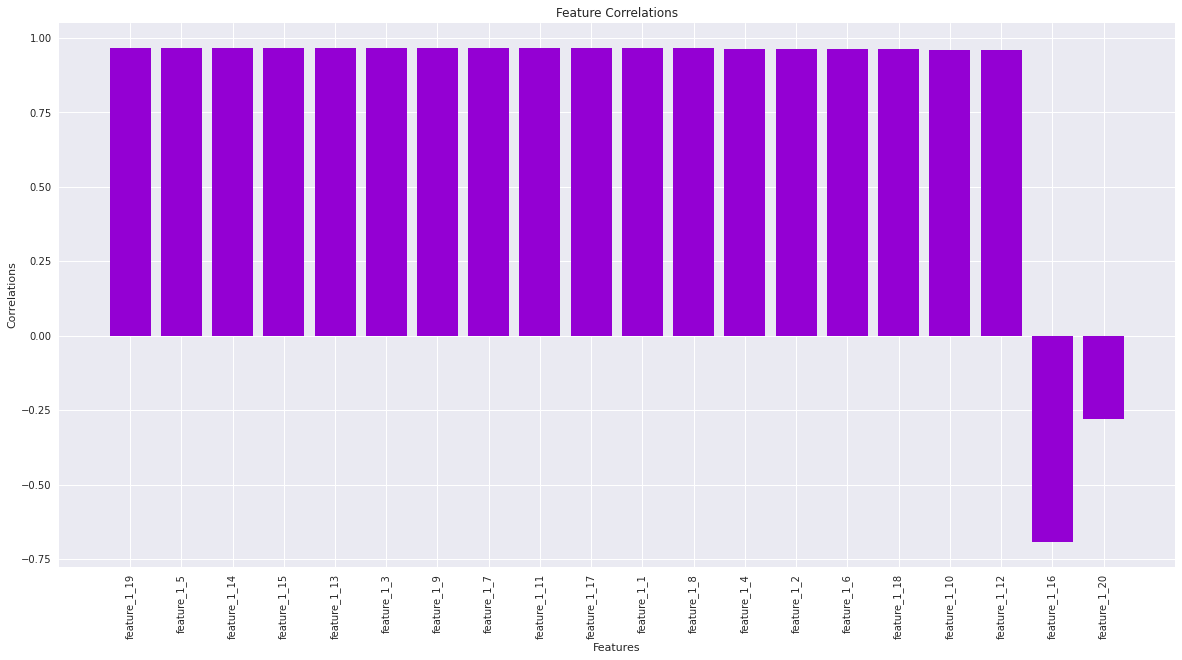

In [13]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color=col_getml)
plt.title("Feature Correlations")
plt.xlabel("Features")
plt.ylabel("Correlations")
plt.xticks(rotation="vertical")
plt.show()

__Feature importances__

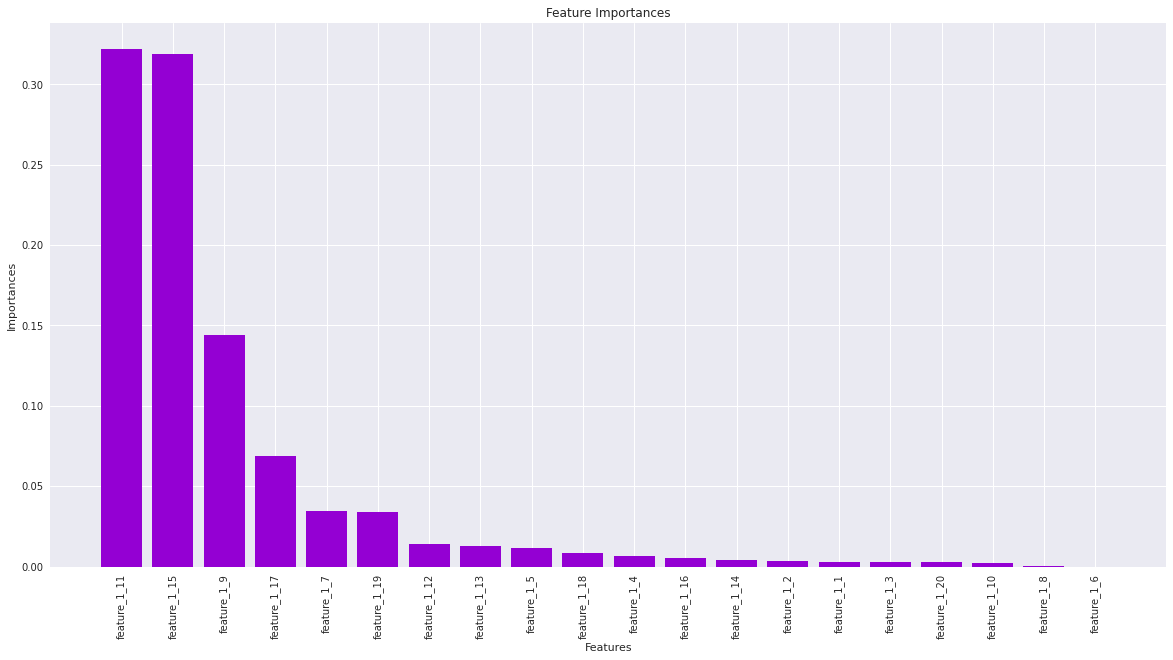

In [14]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color=col_getml)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.xticks(rotation="vertical")
plt.show()

__Visualizing the learned features__

We can also transpile the features as SQL code. Here, we show the most important feature.

In [15]:
by_importance = pipe.features.sort(by="importance")
by_importance[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_11";

CREATE TABLE "FEATURE_1_11" AS
SELECT SUM( 
    CASE
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * 3.057377015603973e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.0004593395626639484 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -1.474637436668939e-05 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -1.474637374503974e-05 + 5.7150119163115356e+01
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -0.0002728656513288804 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * -0.01052883512174053 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 0.0001346630663149147 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * 0.0001346630663124213 + -1.6323205433165185e+02
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -6.39292540060419e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.4011275033288361 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -6.424376251050055e-06 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -6.424376629982775e-06 + 3.3750145068915621e+01
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -1.134613782041478e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.8225011399769877 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -6.017726224043011e-06 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -5.989591316504862e-06 + 1.0654813594208911e+03
        ELSE NULL
    END
) AS "feature_1_11",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds, '+1.000000 hours'" <= t1."ds"
AND ( t2."ds, '+7.041667 days'" > t1."ds" OR t2."ds, '+7.041667 days'" IS NULL )
GROUP BY t1.rowid;
```

To showcase getML's ability to handle categorical data, we now look for features that contain information from the holiday column:

In [16]:
w_holiday = by_importance.filter(lambda feature: "holiday" in feature.sql)
w_holiday

,target,name,correlation,importance
0,traffic_volume,feature_1_12,0.9597,0.014210963
1,traffic_volume,feature_1_5,0.9669,0.011806107
2,traffic_volume,feature_1_18,0.9627,0.008662742
3,traffic_volume,feature_1_4,0.9634,0.006610381
4,traffic_volume,feature_1_14,0.9664,0.003775797
,...,...,...,...
6,traffic_volume,feature_1_1,0.9653,0.00290683
7,traffic_volume,feature_1_3,0.9661,0.002673603
8,traffic_volume,feature_1_10,0.9602,0.002425332
9,traffic_volume,feature_1_8,0.9648,0.000193105


As you can see, getML features which incorporate information about holidays have a rather low importance. This is not that surprising given the fact that most information about holidays is fully reproducible from the extracted calendarial information that is already present. In other words: for the algorithm, it doesn't matter if the traffic is lower on every 4th of July of a given year or if there is a corresponding holiday named 'Independence Day'. Here is the SQL transpilation of the most important feature relying on information about holdidays anyway:

In [17]:
w_holiday[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_12";

CREATE TABLE "FEATURE_1_12" AS
SELECT AVG( 
    CASE
        WHEN ( t1."ds" - t2."ds" > 604379.286214 ) AND ( t2."holiday" IN ( 'No holiday' ) ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * 0.0003660039606263319 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 71.05376583684219 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 0.0003664184040093379 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * 0.0003664184040093365 + -1.2069880432293571e+02
        WHEN ( t1."ds" - t2."ds" > 604379.286214 ) AND ( t2."holiday" NOT IN ( 'No holiday' ) OR t2."holiday" IS NULL ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * 8.012275786483463e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 69.00022214866564 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 8.020852013609209e-05 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * 8.020852013609209e-05 + 5.3012866949926047e+02
        WHEN ( t1."ds" - t2."ds" <= 604379.286214 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t1."ds" - t2."ds" > 6957.303371 ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -1.317464436539947e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.04716876396908531 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -1.320183796749289e-06 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -1.320183796767137e-06 + 7.8258074518998137e+00
        WHEN ( t1."ds" - t2."ds" <= 604379.286214 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t1."ds" - t2."ds" <= 6957.303371 OR t1."ds" IS NULL OR t2."ds" IS NULL ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -0.0001622292968866852 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 9.219306168037313 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -0.000162418776843437 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -0.0001624187768434379 + -9.1605211630897596e+00
        ELSE NULL
    END
) AS "feature_1_12",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds, '+1.000000 hours'" <= t1."ds"
AND ( t2."ds, '+7.041667 days'" > t1."ds" OR t2."ds, '+7.041667 days'" IS NULL )
GROUP BY t1.rowid;
```

__Plot predictions & traffic volume vs. time__

We now plot the predictions against the observed values of the target for the first 7 days of the testing set. You can see that the predictions closely follows the original series. RelMT was able to identify certain patterns in the series, including:
- Day and night separation
- The daily commuting peeks (on weekdays)
- The decline on weekends



In [18]:
predictions = pipe.predict(time_series.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
RelMT: Building features... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          



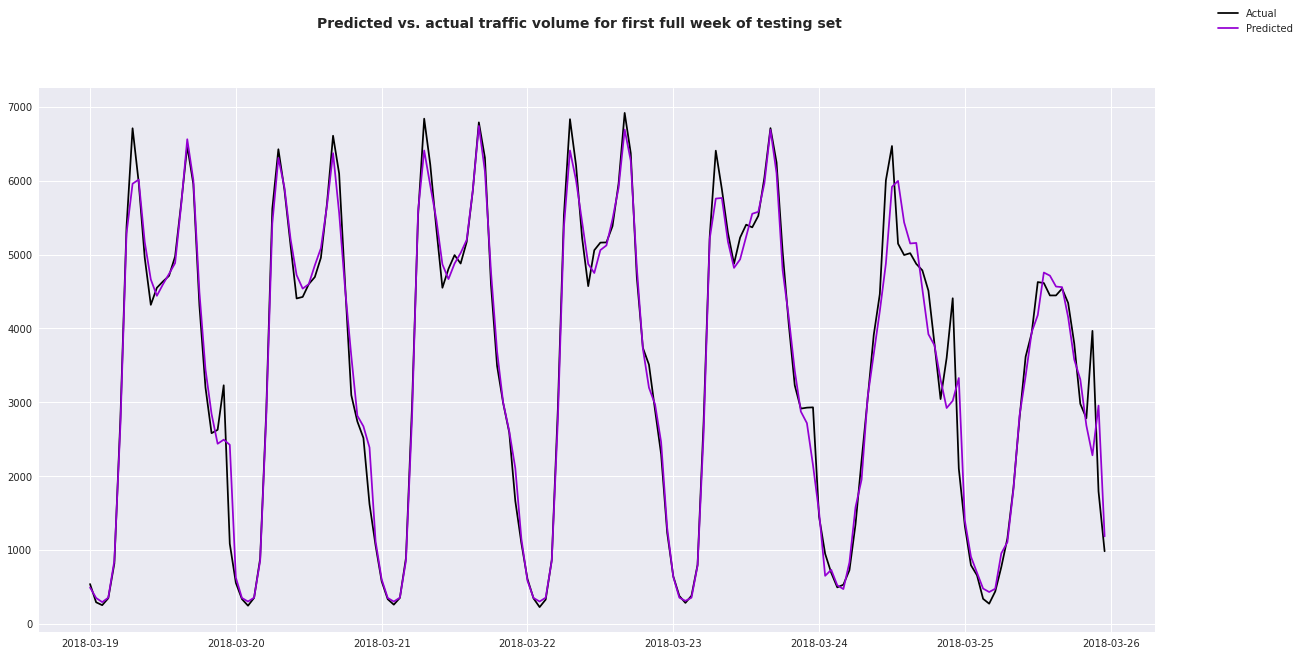

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))

# the test set starts at 2018/03/15 – a thursday; we introduce an offset to, once again, start on a monday
start = 96
end = 96 + 168

actual = time_series.test.population[start:end].to_pandas()
predicted = predictions[start:end]

ax.plot(actual["ds"], actual["traffic_volume"], color=col_data, label="Actual")
ax.plot(actual["ds"], predicted, color=col_getml, label="Predicted")
fig.suptitle(
    "Predicted vs. actual traffic volume for first full week of testing set",
    fontsize=14,
    fontweight="bold",
)
fig.legend()

### 2.5 Features

The most important feature looks as follows:

In [20]:
pipe.features.to_sql()[pipe.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_11";

CREATE TABLE "FEATURE_1_11" AS
SELECT SUM( 
    CASE
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * 3.057377015603973e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.0004593395626639484 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -1.474637436668939e-05 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -1.474637374503974e-05 + 5.7150119163115356e+01
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -0.0002728656513288804 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * -0.01052883512174053 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 0.0001346630663149147 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * 0.0001346630663124213 + -1.6323205433165185e+02
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -6.39292540060419e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.4011275033288361 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -6.424376251050055e-06 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -6.424376629982775e-06 + 3.3750145068915621e+01
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486337853.612977, 0.0 ) * -1.134613782041478e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.8225011399769877 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -6.017726224043011e-06 + COALESCE( t2."ds, '+1.000000 hours'" - 1486339200, 0.0 ) * -5.989591316504862e-06 + 1.0654813594208911e+03
        ELSE NULL
    END
) AS "feature_1_11",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds, '+1.000000 hours'" <= t1."ds"
AND ( t2."ds, '+7.041667 days'" > t1."ds" OR t2."ds, '+7.041667 days'" IS NULL )
GROUP BY t1.rowid;
```

### 2.6 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` module.

In [21]:
# Creates a folder named interstate94_pipeline containing
# the SQL code.
pipe.features.to_sql().save("interstate94_pipeline")

The following files already exist in the directory (interstate94_pipeline):
0001_population__staging_table_1.sql
0002_traffic__staging_table_2.sql
0003_feature_1_1.sql
0004_feature_1_2.sql
0005_feature_1_3.sql
0006_feature_1_4.sql
0007_feature_1_5.sql
0008_feature_1_6.sql
0009_feature_1_7.sql
0010_feature_1_8.sql
0011_feature_1_9.sql
0012_feature_1_10.sql
0013_feature_1_11.sql
0014_feature_1_12.sql
0015_feature_1_13.sql
0016_feature_1_14.sql
0017_feature_1_15.sql
0018_feature_1_16.sql
0019_feature_1_17.sql
0020_feature_1_18.sql
0021_feature_1_19.sql
0022_feature_1_20.sql
0023_features.sql
Please set 'remove=True' to remove them.


## 3. Conclusion

__Benchmarks against Prophet__

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. To retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross-validating the model on a rolling origin. This gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. If you are interested in the full analysis please refer to the extended version of this [notebook](getml_examples/interstate94/interstate94.ipynb).


__Results__

We have benchmarked getML against Facebook’s Prophet library on a univariate time series with strong seasonal components.
Prophet is made for exactly these sort of data sets, so you would expect this to be a home run for Prophet. The opposite is true - getML’s relational learning algorithms outperform Prophet's 1-step ahead predictions by ~15 percentage points:

* R-squared Prophet: 83.3%
* R-squared getML: 98.1%

# Next Steps

This tutorial went through the basics of applying getML to time series.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.